# Kalman Filter
In this exercise, we will develop the Kalman Filter (KF) for the one-dimensional case and explore its key functions. 

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ipywidgets import interactive
from scipy.stats import multivariate_normal

from StateSpaceDisplay import state_space_display, state_space_display_updated

pylab.rcParams['figure.figsize'] = 10, 10

For simplicity, the drone can only move in the vertical direction, and the state is the vertical position and velocity,

$$
x = \begin{bmatrix} \dot{z} \\ z \end{bmatrix}
$$

The control input for the drone is the vertical acceleration $u = [\ddot{z}]$. 

The drone also has uncertainty associated with it's measurements (covariance matrix Q) and state predictions (covariance matrix R), which arise from the accuracy of the sensor and the drone's ability to precisely execute a given command.

The transition function has the following form:

$$
g(x_t,u_t,\Delta t) = \begin{bmatrix} 1 & 0 \\ \Delta t & 1 \end{bmatrix} \begin{bmatrix} \dot{z}\\z \end{bmatrix} + \begin{bmatrix} \Delta t \\ 0 \end{bmatrix} \begin{bmatrix} \ddot{z} \end{bmatrix}  = A_t x_t+B_tu_t
$$

The partial derivative of $g$ with respect to x is:

$$
g'(x_t,u_t,\Delta t) = \begin{bmatrix} 1 & 0 \\ \Delta t & 1   \end{bmatrix}
$$

In [2]:
class KF:
    def __init__(self,
                 measurement_noise,         # Uncertainty that is present in every measurement
                 process_noise_v,           # Uncertainty 
                 process_noise_p,           # Uncertainty 
                 dt                         # dt time between samples 
                ):
        
        # Process noise
        # This is determined experimentally based on the vehicle model; usually remains constant. 
        self.q_t = np.array([[process_noise_v**2, 0.0],
                             [0.0, process_noise_p**2]])
        
        # Measurement noise
        # This is read off a datasheet or determined experimentally; usually remains constant.
        self.r_t =  np.array([measurement_noise**2])
        
        self.dt = dt
        
        # Default velocity, position - [0,0]
        self.mu = np.array([[0.0],
                            [0.0]])
        
        # Default covariance - complete certainty
        self.sigma = np.array([[0.0, 0.0],
                               [0.0, 0.0]])
        
        self.mu_bar = self.mu
        self.sigma_bar = self.sigma

    @property
    def a(self):
        return np.array([[1.0, 0.0],
                         [self.dt, 1.0]])

    @property
    def b(self):
        return np.array([[self.dt],
                         [0.0]])

    def g(self, 
          mu,
          u            # Control input u = [\ddot{z}]
          ):
        '''Calculates the state transition function. '''
        # TODO: return the g matrix using the A and B matrices 
        
        return np.matmul(self.a, mu) + self.b * u

    def g_prime(self):
        '''The partial derivative of the state transition function.'''
        # TODO: return the matrix that represents the partial derivative of the g matrix
        
        return self.a


    def initial_values(self, 
                       mu_0, 
                       sigma_0):

        '''Setting the initial state for the drone'''

        self.mu = mu_0
        self.sigma = sigma_0

## Predict Step

The KF predicts the next state based on the previous state and the motion the drone undertook since then.

Based on the previous mean and covariance values of the altitude we can predict the new mean and covariance values and estimate the current state. 

In [3]:
%%add_to KF

def predict(self, 
            u             # Control input 
           ):

    '''Prediction step of the Kalman Filter'''

    # TODO: Implement the prediction step 
    # The formulas were provided in the preceding lessons and in the document: https://www.overleaf.com/read/vymfngphcccj  
    
    mu_bar = self.g(self.mu, u)
    G = self.g_prime()
    
    # This is how to multiply G(sigma)G.T in order using np.matmul
    sigma_bar = np.matmul(G, np.matmul(self.sigma, np.transpose(G))) + self.q_t

    self.mu_bar = mu_bar
    self.sigma_bar = sigma_bar

    return mu_bar, sigma_bar

## Initialize Kalman Filter

In [4]:
measurement_noise = 0.1         # Measurement noise
process_noise_v = 0.1           # Process noise, velocity
process_noise_p = 0.1           # Process noise, position

v = 1.0                         # Initial velocity
z = 0.0                         # Initial position

dt = 1.0                        # The time difference between measurements

velocity_sigma = 0.1            # Initial velocity uncertainty
position_sigma = 0.1            # Initial position uncertainty

mu_0 = np.array([[v],
                 [z]]) 

sigma_0 = np.array([[velocity_sigma**2, 0.0],
                    [0.0, position_sigma**2]])

u = np.array([0.0])     # no control input is given \ddot{z} = 0 

In [5]:
# Initialize the object
myKF = KF(measurement_noise, process_noise_v, process_noise_p, dt)

# Input the initial values 
myKF.initial_values(mu_0, sigma_0)

# Call the predict function
mu_bar, sigma_bar = myKF.predict(u)

# Print the new values for the mean and covariance
print('mu_bar = \n', mu_bar)
print('\nsigma_bar = \n', sigma_bar)

mu_bar = 
 [[1.]
 [1.]]

sigma_bar = 
 [[0.02 0.01]
 [0.01 0.03]]


Plotting the initial and predicted estimates.


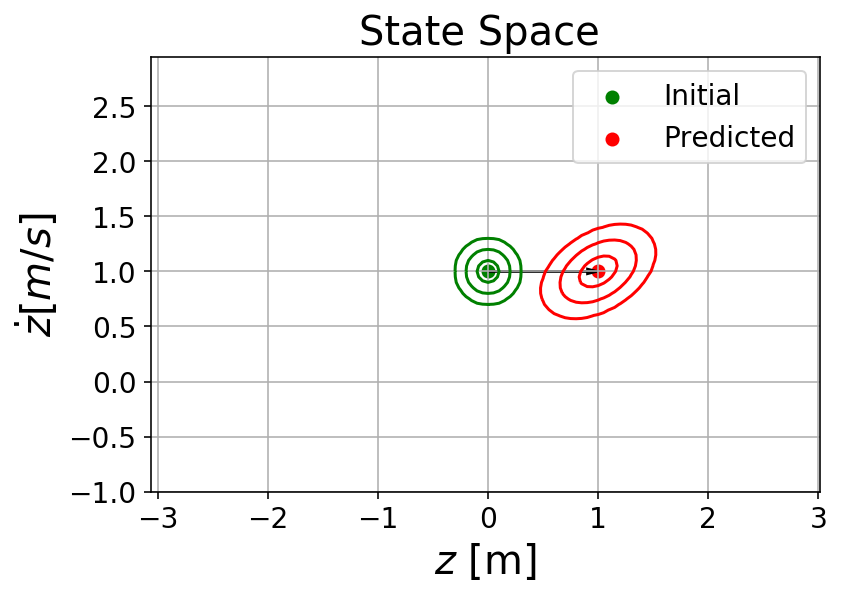

In [6]:
state_space_display(z, v, mu_0, sigma_0, mu_bar, sigma_bar)

## Measurement Update

In this section, we will update the state vector mean position and the covariance based on the measurement that we perform after executing the move. 

$$
h= \begin{bmatrix} 0 & 1  \end{bmatrix} \times \begin{bmatrix}\dot{z} \\ z  \end{bmatrix}
$$

Thus 
$$
h' = \begin{bmatrix} 0 & 1 \end{bmatrix}
$$

In [13]:
%%add_to KF

def h(self,mu):
    return np.matmul(np.array([[0.0, 1.0]]), mu) 

def h_prime(self):
    return np.array([[0.0, 1.0]])

def update(self, 
           z             # Measurement 
          ):
    '''Measurement Update step of the Kalman Filter'''
    
    # TODO: Implement the measurement update step. 
    # The formulas were provided in the preceding lessons and in the document: https://www.overleaf.com/read/vymfngphcccj    
    
    H = self.h_prime()
    S = np.matmul(np.matmul(H, self.sigma_bar), np.transpose(H)) + self.r_t
    K = np.matmul(np.matmul(self.sigma_bar, np.transpose(H)), np.linalg.inv(S))
    
    mu = self.mu_bar + np.matmul(K, (z - self.h(self.mu_bar)))
    sigma = np.matmul((np.identity(2) - np.matmul(K, H)), self.sigma_bar)
    
    self.mu = mu
    self.sigma = sigma
    
    return mu, sigma

We'll introduce a single measurement close to the predicted position and update the drone's estimated position.

In [14]:
measure = 1.01

mu_updated, sigma_updated = myKF.update(measure)

print('Updated mean = \n', mu_updated)
print('\nUpdated sigma = \n', sigma_updated)

Updated mean = 
 [[1.0025]
 [1.0075]]

Updated sigma = 
 [[0.0175 0.0025]
 [0.0025 0.0075]]


Plotting the initial, predicted, and updated estimates.

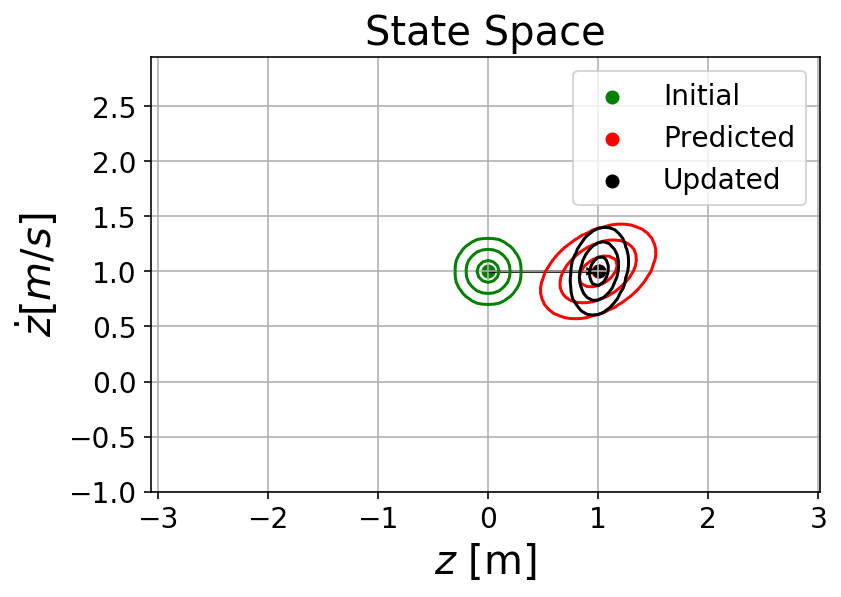

In [15]:
state_space_display_updated(z, v, mu_0, sigma_0, mu_bar, sigma_bar, mu_updated, sigma_updated)

Please note that if you have peformed all operations correctly the updated state should be better defined than the initial state and the predicted state (the ovals should occupy a smaller area).

### KF + PID

In this section, we will once again ask our drone to hover at a constant height of -1m, but this time we will use a Kalman Filter to estimate the drone's altitude, instead of averaging as we had done previously.

In [18]:
from CoaxialDrone import CoaxialCopter
from PIDcontroller import PIDController_with_ff
from PathGeneration import flight_path

First, we will generate a flight path, which will be a constant height of -1m. 

In [19]:
total_time = 10.0  # Total flight time
dt = 0.01          # Time intervale between measurements 

t, z_path, z_dot_path, z_dot_dot_path =  flight_path(total_time, dt,'constant' )

###  Sensing

To generate the measurement data, we will simulate a range-finding sensor by adding noise to the actual altitude measurements.

In [24]:
class Sensor:
    def __init__(self):
        pass
        
    def measure(self, z, sigma=0.001): 
        return z + np.random.normal(0.0, sigma)

In [25]:
from DronewithPIDControllerKF import DronewithPIDKF

In [26]:
sensor_error  = 0.1
velocity_sigma = 0.1
position_sigma = 0.1 
MYKF = KF(sensor_error, velocity_sigma, position_sigma, dt)

Let's compare two estimates of the drone's altitude:

- the estimate produced by the Kalman Filter,
- the estimate we obtained earlier, using the measurements directly.

The graph below will display the estimate obtained by using the measurements directly. By checking the use_kf checkbox, you can see the estimate produced by the Kalman Filter. 

In [27]:
# Initializing the drone with PID controller and providing information of the desired flight path. 
FlyingDrone = DronewithPIDKF(z_path, z_dot_path, z_dot_dot_path, t, dt, Sensor, KF)

In [28]:
interactive_plot = interactive(FlyingDrone.PID_controller_with_KF, 
                               position_sigma = (0.0, 0.1, 0.001),
                               motion_sigma = (0.0, 0.1, 0.001))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(FloatSlider(value=0.05, description='position_sigma', max=0.1, step=0.001), FloatSlider(…

This section will allow you to test the different PID controller parameters and compare flight path when using the direct measurement and the KF estimated value to control the drone. 

In [29]:
from DronewithPIDControllerKF import DronewithPIDKFKnobs

In [30]:
FlyingDroneKnobs = DronewithPIDKFKnobs(z_path, z_dot_path, z_dot_dot_path, t, dt, Sensor, KF)

In [31]:
interactive_plot = interactive(FlyingDroneKnobs.PID_controller_with_KF_knobs,
                               k_p=(5.0, 35.0, 1),
                               k_d=(0.0, 10, 0.5), 
                               k_i=(0.0, 10, 0.5), 
                               mass_err =(0.7, 1.31, 0.01),
                               sigma = (0.0, 0.1, 0.001),
                               position_sigma = (0.0, 0.1, 0.001),
                               motion_sigma = (0.0, 0.1, 0.001))

output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(FloatSlider(value=20.0, description='k_p', max=35.0, min=5.0, step=1.0), FloatSlider(val…

[Solution](./Kalman_Filter-Solution.ipynb)